<a href="https://colab.research.google.com/github/Milonahmed96/Credit-Risk-AI/blob/main/notebooks/03_tree_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Modeling (XGBoost)
While Logistic Regression provides a strong, interpretable baseline, credit behavior often contains non-linear relationships (e.g., the compounding risk of high utilization combined with late payments). In this phase, we train an XGBoost classifier to capture these complex interactions.

We address the class imbalance using the `scale_pos_weight` parameter, which is the gradient boosting equivalent of class weights.

In [1]:
# Install shap if not already installed in the environment
!pip -q install shap xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import shap
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

warnings.filterwarnings('ignore')

# Set consistent visualization parameters
plt.rcParams.update({
    'font.family': 'sans-serif',
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 120
})
sns.set_style("whitegrid")

# Load processed datasets
train_data = pd.read_csv('train_processed.csv')
test_data = pd.read_csv('test_processed.csv')

X_train = train_data.drop('default', axis=1)
y_train = train_data['default']
X_test = test_data.drop('default', axis=1)
y_test = test_data['default']

# Calculate ratio of negative to positive class for scale_pos_weight
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=class_ratio,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

print("XGBoost model training complete.")

XGBoost model training complete.


# Advanced Model Evaluation
We evaluate the XGBoost model using the same banking-specific metrics applied to the baseline model (ROC-AUC and PR-AUC) to determine if the non-linear algorithm provides a measurable lift in distinguishing default risk.

In [2]:
# Generate probability predictions
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_default_xgb = (y_pred_prob_xgb >= 0.5).astype(int)

roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
pr_auc_xgb = average_precision_score(y_test, y_pred_prob_xgb)

print("XGBoost Evaluation Metrics (Threshold = 0.50)")
print(f"ROC-AUC Score: {roc_auc_xgb:.4f}")
print(f"PR-AUC Score:  {pr_auc_xgb:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_default_xgb, target_names=['Non-Default (0)', 'Default (1)']))

XGBoost Evaluation Metrics (Threshold = 0.50)
ROC-AUC Score: 0.7803
PR-AUC Score:  0.5561

Classification Report:
                 precision    recall  f1-score   support

Non-Default (0)       0.88      0.78      0.83      4673
    Default (1)       0.45      0.63      0.53      1327

       accuracy                           0.75      6000
      macro avg       0.67      0.71      0.68      6000
   weighted avg       0.79      0.75      0.76      6000



# Global Explainability via SHAP
Gradient boosting models are historically viewed as "black boxes," which is unacceptable in regulatory finance. We utilize SHAP (SHapley Additive exPlanations) to decompose the model's predictions. The SHAP summary plot illustrates both feature importance (y-axis) and the directional impact of feature values on the default probability (color and x-axis).

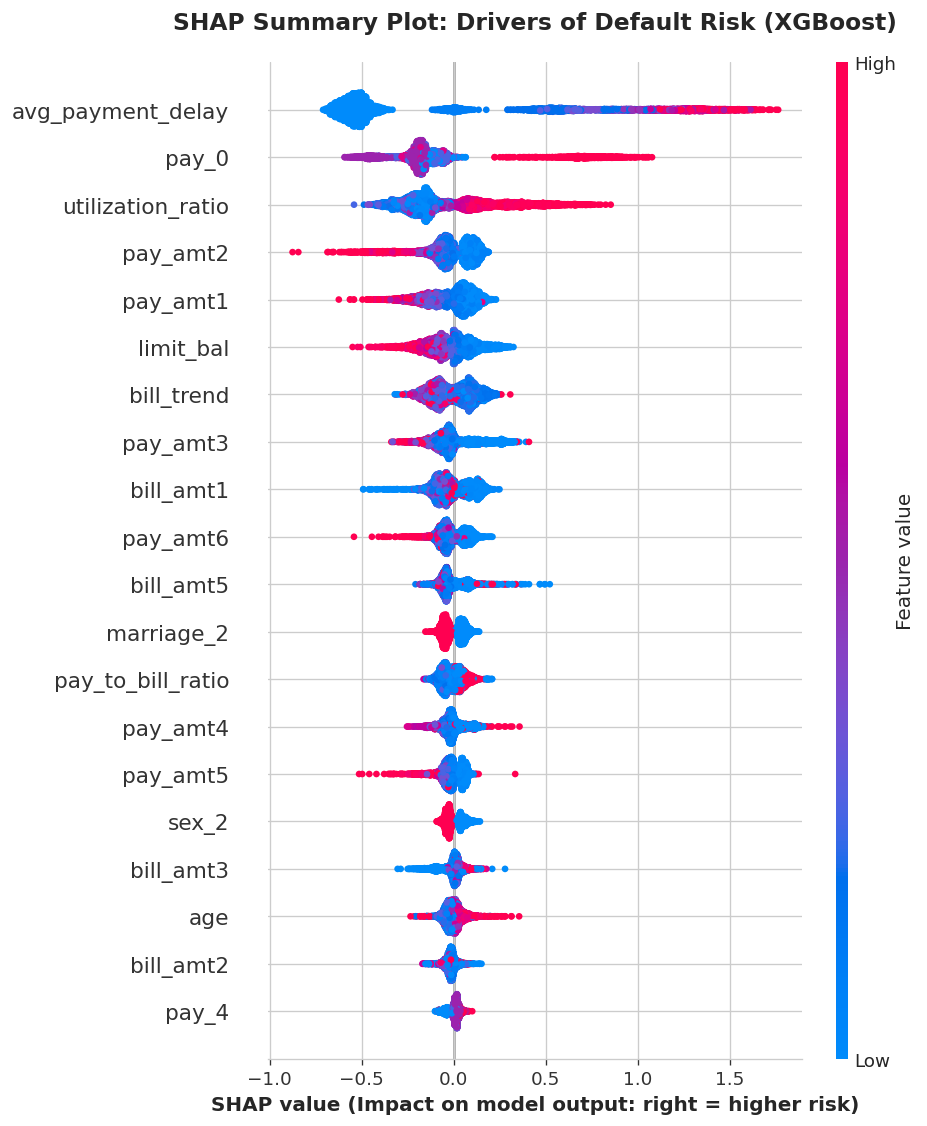

In [3]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
# Using a sample if the test set is exceptionally large to save computation time,
# but 6,000 rows (20% of 30k) processes quickly enough.
shap_values = explainer.shap_values(X_test)

# Visualize SHAP Summary Plot
plt.figure(figsize=(10, 8))
plt.title("SHAP Summary Plot: Drivers of Default Risk (XGBoost)", fontweight='bold', fontsize=14, pad=20)
shap.summary_plot(shap_values, X_test, show=False)

# Adjust plot aesthetics to match the project theme
fig = plt.gcf()
fig.set_dpi(120)
plt.xlabel("SHAP value (Impact on model output: right = higher risk)", fontsize=12, fontweight='bold')
plt.show()